Initial imports of necessary packages


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import time
from sklearn.metrics import accuracy_score,  f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA, NMF
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_fscore_support, log_loss
import random
import time
import collections
import warnings
from scipy.stats import pearsonr, spearmanr

%matplotlib inline

Read in Train, Test and Label csv files as Pandas dataframes

In [ ]:
train_tcga_df = pd.read_csv('../data/train_tcga_expression_matrix_processed.tsv', header=0, sep='\t')
test_tcga_df = pd.read_csv('../data/test_tcga_expression_matrix_processed.tsv', header=0, sep='\t')

labels_tcga_df = pd.read_csv('../data/tcga_sample_identifiers.tsv', header=0, sep='\t')

The final TCGA PanCanAtlas gene expression matrix with 11060 samples, which included 33 different cancer types, and 16148 genes.

With a 90/10 train/test split, this results in 9954/1106 train test sample split, with 16149 cols (1 added col for 'sample_id')

Load first 5 samples in each of the dataframes to obtain a feel for the structure of the data

In [ ]:
train_tcga_df.head()

,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
0,TCGA-LL-A73Z-01,202.0,28.5,329.0,84.5,492.0,448.0,4.590,14.70,337.0,...,3430.0,717.0,1800.0,6360.0,299.0,2310.0,10.60,3190.0,337.0,892.0
1,TCGA-55-8207-01,77.5,22.5,74.5,13.1,784.0,333.0,2.540,176.00,153.0,...,6050.0,923.0,2490.0,11300.0,1150.0,4030.0,9.08,2890.0,316.0,301.0
2,TCGA-FF-A7CR-01,152.0,0.0,3020.0,26.6,486.0,497.0,0.000,8.47,348.0,...,4930.0,897.0,861.0,39.7,464.0,3320.0,0.00,1330.0,606.0,558.0
3,TCGA-BK-A13C-11,80.5,40.0,70.6,284.0,2420.0,325.0,1.200,91.40,231.0,...,3890.0,737.0,1410.0,10.9,1120.0,1990.0,5.24,3090.0,673.0,263.0
4,TCGA-EB-A6L9-06,319.0,0.0,422.0,184.0,423.0,392.0,0.945,2.36,585.0,...,1930.0,328.0,1340.0,7010.0,450.0,563.0,10.90,3780.0,37.3,1120.0


In [ ]:
test_tcga_df.head()

,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
0,TCGA-CN-5365-01,70.5,0.000,1310.0,18.70,73.9,757.0,1.82,10.50,414.0,...,2730.0,612.0,5780.0,10400.0,879.0,3830.0,4.10,4220.0,308.0,1300.0
1,TCGA-LP-A7HU-01,27.8,0.949,517.0,6.17,63.6,365.0,4.27,9.02,633.0,...,4510.0,543.0,1360.0,4960.0,510.0,2220.0,17.60,2410.0,233.0,993.0
2,TCGA-22-5491-11,87.6,3.760,88.3,14.40,642.0,295.0,6.84,59.90,159.0,...,4420.0,479.0,2190.0,4480.0,870.0,2120.0,5.13,5030.0,285.0,530.0
3,TCGA-CS-6667-01,75.8,0.000,55.6,2720.00,2170.0,281.0,3.90,9.57,251.0,...,5460.0,1550.0,1370.0,12.8,1430.0,601.0,23.70,7530.0,473.0,258.0
4,TCGA-20-1684-01,63.1,0.703,75.2,4500.00,792.0,433.0,1.64,4.16,623.0,...,5200.0,812.0,1070.0,8410.0,505.0,1170.0,14.80,1910.0,281.0,221.0


In [ ]:
labels_tcga_df.head()

,sample_id,sample_type,cancer_type
0,TCGA-02-0047-01,Primary Solid Tumor,GBM
1,TCGA-02-0055-01,Primary Solid Tumor,GBM
2,TCGA-02-2483-01,Primary Solid Tumor,GBM
3,TCGA-02-2485-01,Primary Solid Tumor,GBM
4,TCGA-02-2486-01,Primary Solid Tumor,GBM


Create dataframe with all training and test samples

In [ ]:
tcga_merged_df = train_tcga_df.append(test_tcga_df, ignore_index=True)
print(tcga_merged_df.shape)
tcga_merged_df.head()

(11060, 16149)


,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
0,TCGA-LL-A73Z-01,202.0,28.5,329.0,84.5,492.0,448.0,4.590,14.70,337.0,...,3430.0,717.0,1800.0,6360.0,299.0,2310.0,10.60,3190.0,337.0,892.0
1,TCGA-55-8207-01,77.5,22.5,74.5,13.1,784.0,333.0,2.540,176.00,153.0,...,6050.0,923.0,2490.0,11300.0,1150.0,4030.0,9.08,2890.0,316.0,301.0
2,TCGA-FF-A7CR-01,152.0,0.0,3020.0,26.6,486.0,497.0,0.000,8.47,348.0,...,4930.0,897.0,861.0,39.7,464.0,3320.0,0.00,1330.0,606.0,558.0
3,TCGA-BK-A13C-11,80.5,40.0,70.6,284.0,2420.0,325.0,1.200,91.40,231.0,...,3890.0,737.0,1410.0,10.9,1120.0,1990.0,5.24,3090.0,673.0,263.0
4,TCGA-EB-A6L9-06,319.0,0.0,422.0,184.0,423.0,392.0,0.945,2.36,585.0,...,1930.0,328.0,1340.0,7010.0,450.0,563.0,10.90,3780.0,37.3,1120.0


Print shape of each of the dfs

In [ ]:
print("Train df Shape", train_tcga_df.shape)
print("Test df Shape", test_tcga_df.shape)
print("Labels df Shape", labels_tcga_df.shape)
print("Merged df Shape", tcga_merged_df.shape)

Train df Shape (9954, 16149)
Test df Shape (1106, 16149)
Labels df Shape (11060, 3)
Merged df Shape (11060, 16149)


Obtain the list of 'Sample ID' (Indicator Variable)  in each of the dataframes, and use them to append the cancer type (aka the Y variable) from the labels df onto the train and test df

In [ ]:
train_id = train_tcga_df['sample_id']
test_id = test_tcga_df['sample_id']
label_id = labels_tcga_df['sample_id']
merge_id  = tcga_merged_df['sample_id']

In [ ]:
merge_train = []
merge_test = []
merge_full = []

for i in train_id:
    val = labels_tcga_df.loc[labels_tcga_df['sample_id'] == i]
    merge_train.append(str(val['cancer_type']).split()[1])
    
for i in test_id:
    val = labels_tcga_df.loc[labels_tcga_df['sample_id'] == i]
    merge_test.append(str(val['cancer_type']).split()[1])
  
for i in merge_id:
    val = labels_tcga_df.loc[labels_tcga_df['sample_id'] == i]
    merge_full.append(str(val['cancer_type']).split()[1])

In [ ]:
tcga_merged_df['cancer_type'] = merge_full
print(tcga_merged_df.shape)
tcga_merged_df.head()

(11060, 16150)


,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9988,9989,999,9990,9991,9992,9993,9994,9997,cancer_type
0,TCGA-LL-A73Z-01,202.0,28.5,329.0,84.5,492.0,448.0,4.590,14.70,337.0,...,717.0,1800.0,6360.0,299.0,2310.0,10.60,3190.0,337.0,892.0,BRCA
1,TCGA-55-8207-01,77.5,22.5,74.5,13.1,784.0,333.0,2.540,176.00,153.0,...,923.0,2490.0,11300.0,1150.0,4030.0,9.08,2890.0,316.0,301.0,LUAD
2,TCGA-FF-A7CR-01,152.0,0.0,3020.0,26.6,486.0,497.0,0.000,8.47,348.0,...,897.0,861.0,39.7,464.0,3320.0,0.00,1330.0,606.0,558.0,DLBC
3,TCGA-BK-A13C-11,80.5,40.0,70.6,284.0,2420.0,325.0,1.200,91.40,231.0,...,737.0,1410.0,10.9,1120.0,1990.0,5.24,3090.0,673.0,263.0,UCEC
4,TCGA-EB-A6L9-06,319.0,0.0,422.0,184.0,423.0,392.0,0.945,2.36,585.0,...,328.0,1340.0,7010.0,450.0,563.0,10.90,3780.0,37.3,1120.0,SKCM


Print shape of each of the dfs

In [ ]:
print("Train df Shape", train_tcga_df.shape)
print("Test df Shape", test_tcga_df.shape)
print("Labels df Shape", labels_tcga_df.shape)

Train df Shape (9954, 16149)
Test df Shape (1106, 16149)
Labels df Shape (11060, 3)


Obtain the list of 'Sample ID' (Indicator Variable)  in each of the dataframes, and use them to append the cancer type (aka the Y variable) from the labels df onto the train and test df

In [ ]:
train_id = train_tcga_df['sample_id']
test_id = test_tcga_df['sample_id']
label_id = labels_tcga_df['sample_id']

In [ ]:
merge_train = []
merge_test = []

for i in train_id:
    val = labels_tcga_df.loc[labels_tcga_df['sample_id'] == i]
    merge_train.append(str(val['cancer_type']).split()[1])
    
for i in test_id:
    val = labels_tcga_df.loc[labels_tcga_df['sample_id'] == i]
    merge_test.append(str(val['cancer_type']).split()[1])

Create new col in train and test with the cancer type added in

In [ ]:
train_tcga_df['cancer_type'] = merge_train
print(train_tcga_df.shape)
train_tcga_df.head()

(9954, 16150)


,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9988,9989,999,9990,9991,9992,9993,9994,9997,cancer_type
0,TCGA-LL-A73Z-01,202.0,28.5,329.0,84.5,492.0,448.0,4.590,14.70,337.0,...,717.0,1800.0,6360.0,299.0,2310.0,10.60,3190.0,337.0,892.0,BRCA
1,TCGA-55-8207-01,77.5,22.5,74.5,13.1,784.0,333.0,2.540,176.00,153.0,...,923.0,2490.0,11300.0,1150.0,4030.0,9.08,2890.0,316.0,301.0,LUAD
2,TCGA-FF-A7CR-01,152.0,0.0,3020.0,26.6,486.0,497.0,0.000,8.47,348.0,...,897.0,861.0,39.7,464.0,3320.0,0.00,1330.0,606.0,558.0,DLBC
3,TCGA-BK-A13C-11,80.5,40.0,70.6,284.0,2420.0,325.0,1.200,91.40,231.0,...,737.0,1410.0,10.9,1120.0,1990.0,5.24,3090.0,673.0,263.0,UCEC
4,TCGA-EB-A6L9-06,319.0,0.0,422.0,184.0,423.0,392.0,0.945,2.36,585.0,...,328.0,1340.0,7010.0,450.0,563.0,10.90,3780.0,37.3,1120.0,SKCM


In [ ]:
test_tcga_df['cancer_type'] = merge_test
print(test_tcga_df.shape)
test_tcga_df.head()

(1106, 16150)


,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9988,9989,999,9990,9991,9992,9993,9994,9997,cancer_type
0,TCGA-CN-5365-01,70.5,0.000,1310.0,18.70,73.9,757.0,1.82,10.50,414.0,...,612.0,5780.0,10400.0,879.0,3830.0,4.10,4220.0,308.0,1300.0,HNSC
1,TCGA-LP-A7HU-01,27.8,0.949,517.0,6.17,63.6,365.0,4.27,9.02,633.0,...,543.0,1360.0,4960.0,510.0,2220.0,17.60,2410.0,233.0,993.0,CESC
2,TCGA-22-5491-11,87.6,3.760,88.3,14.40,642.0,295.0,6.84,59.90,159.0,...,479.0,2190.0,4480.0,870.0,2120.0,5.13,5030.0,285.0,530.0,LUSC
3,TCGA-CS-6667-01,75.8,0.000,55.6,2720.00,2170.0,281.0,3.90,9.57,251.0,...,1550.0,1370.0,12.8,1430.0,601.0,23.70,7530.0,473.0,258.0,LGG
4,TCGA-20-1684-01,63.1,0.703,75.2,4500.00,792.0,433.0,1.64,4.16,623.0,...,812.0,1070.0,8410.0,505.0,1170.0,14.80,1910.0,281.0,221.0,OV


To conserve RAM usage, we delete computed variables when are done using them. First we delete the labels matrix, as we have already appended cancer type to train and test matrices

In [ ]:
del labels_tcga_df

Function to Perform Logistic Regression, and return accuracy and runtime of classifier


In [ ]:
def runLR(df2, test2):

    #LR Classifier with 16148 feature dimensionality
    start_time = time.time()
    clf = LogisticRegression(random_state=0).fit(df2.iloc[:,:-1],df2["cancer_type"])
    pred = clf.predict(test2.iloc[:,:-1])
    LR_accuracy = accuracy_score(test2.cancer_type,pred)
    LR_computation_time = time.time() - start_time

    del clf

    return LR_accuracy, LR_computation_time

Function to Perform SVM Classification, and return accuracy and runtime of classifier


In [ ]:
def runSVM(df2, test2):

    start_time = time.time()
    clf = SVC(random_state=0).fit(df2.iloc[:,:-1],df2["cancer_type"])
    pred = clf.predict(test2.iloc[:,:-1])
    SVM_accuracy = accuracy_score(test2.cancer_type,pred)
    SVM_computation_time = time.time() - start_time

    del clf

    return SVM_accuracy, SVM_computation_time

Function to recontruct original featureset from scores and loadings

In [ ]:
def compile_reconstruction(input_df,nmf_df,nmf,ctype,k,test=False):
        """
        Compile reconstruction costs between input and algorithm reconstruction
        Arguments:
        Two dictionaries storing 1) reconstruction costs and 2) reconstructed
        matrix for each algorithm
        nmf - model used for data reduction
        nmf_df - matrix in reduced component space
        input_df - original featureset, used for setting values of col names in pandas
        """
        
        
        
        nmf_reconstruct_mat = nmf.inverse_transform(nmf_df)
        
        reconstruct_mat = pd.DataFrame(nmf_reconstruct_mat,
                                              index=input_df.index,
                                              columns=input_df.columns)

        return reconstruct_mat


Function to Scale Data before performing NMF. This Function scales data around a Gaussian (Normal) distribution, before shifting the distribution to ensure non-negative entries

In [ ]:
def NMF_scale(df2,test2):
    '''
    df2 - train dataframe
    test2 - test dataframe
    '''

    #StandardScaler shifts data to follow Gaussian distribution
    standard_train = StandardScaler()
    result_train = standard_train.fit_transform(df2.iloc[:,:-1])
    result_train = pd.DataFrame(result_train)

    #MinMax shifts data to ensure no negative values
    scaler_train = MinMaxScaler()
    result_train=scaler_train.fit_transform(result_train.iloc[:,:-1])
    result_train = pd.DataFrame(result_train)
    

    #Repeat procedure for test dataframe
    standard_test = StandardScaler()
    result_test = standard_test.fit_transform(test2.iloc[:,:-1])
    result_test = pd.DataFrame(result_test)

    scaler_test = MinMaxScaler()
    result_test=scaler_test.fit_transform(result_test.iloc[:,:-1])
    result_test = pd.DataFrame(result_test)

    return result_train, result_test

Function to Scale Data before performing PCA/ICA. This Function scales data around a Gaussian (Normal) distribution.

In [ ]:
def PCA_scale(df2,test2):
    standard_train = StandardScaler()
    result_train = standard_train.fit_transform(df2.iloc[:,:-1])
    result_train = pd.DataFrame(result_train)

    #MinMax shifts data to ensure no negative values
    # result_train.to_csv ('/content/drive/MyDrive/BE275_Project/nmf/input_train_{}.csv'.format(ctype))
    
    standard_test = StandardScaler()
    result_test = standard_test.fit_transform(test2.iloc[:,:-1])
    result_test = pd.DataFrame(result_test)
    # result_test.to_csv ('/content/drive/MyDrive/BE275_Project/nmf/input_test_{}.csv'.format(ctype))

    return result_train, result_test

Compute NMF on Scaled Data, and return reconstructed matrices, scores and computation time

In [ ]:
def returnNMF(result_train, result_test, ctype, k):

    '''
    result_train - scaled train dataframe
    result_test - scaled test dataframe
    ctype - cancertype we aim to detect
    k - no. of components
    '''
    
    start_time = time.time()
    

    #ensure n_comp does not exceed no. of features
    n_comp= min(k, result_train.shape[0])

    # Define NMF Model
    nmf = NMF(n_components=n_comp)
    
    # NMF Model Fitting for Train Set
    nmf_comp_train = nmf.fit_transform(result_train)
    colnames = ['nmf_{}'.format(x) for x in range(0, n_comp)]

    #Store NMF matrix and weights in csv
    nmf_comp_train = pd.DataFrame(nmf_comp_train,
                               columns=colnames,index=result_train.index)
    
    nmf_weights_train = pd.DataFrame(nmf.components_,
                                        columns=result_train.columns,
                                        index=colnames)
    
    nmf_time = time.time()-start_time
    
    # NMF Transform on the Test Set
    nmf_comp_test = nmf.transform(result_test)
    nmf_comp_test = pd.DataFrame(nmf_comp_test,
                               columns=colnames,index=result_test.index)

    # compile reconstruction 
    reconstruct_mat_train = compile_reconstruction(result_train,nmf_comp_train ,nmf,ctype,k)
    reconstruct_mat_test = compile_reconstruction(result_test, nmf_comp_test, nmf,ctype,k)

    #Delete model to save RAM usage
    del nmf
    
    #return nmf scores from train and test, reconstruction from train and test, and computation time
    return reconstruct_mat_train, reconstruct_mat_test, nmf_comp_train, nmf_comp_test, nmf_time



Compute ICA on Scaled Data, and return reconstructed matrices, scores and computation time

In [ ]:
def returnICA(result_train, result_test, k):
    # warnings.filterwarnings("ignore")
    
    start_time = time.time()
    

    #ensure n_comp does not exceed no. of features
    n_comp= min(k, result_train.shape[0])

    # Define ICA Model
    ica = FastICA(n_components=n_comp)
    
    # ICA Model Fitting for Train Set
    ica_comp_train = ica.fit_transform(result_train)
    colnames = ['ica_{}'.format(x) for x in range(0, n_comp)]

    #Store NMF matrix and weights in csv
    ica_comp_train = pd.DataFrame(ica_comp_train,
                               columns=colnames,index=result_train.index)
    ica_weights_train = pd.DataFrame(ica.components_,
                                        columns=result_train.columns,
                                        index=colnames)
    ica_time = time.time()-start_time
    
    # NMF Transform on the Test Set
    ica_comp_test = ica.transform(result_test)
    ica_comp_test = pd.DataFrame(ica_comp_test,
                               columns=colnames,index=result_test.index)

    # compile reconstruction 
    reconstruct_mat_train = compile_reconstruction(result_train,ica_comp_train ,ica)
    reconstruct_mat_test = compile_reconstruction(result_test, ica_comp_test, ica)

    
    return reconstruct_mat_train, reconstruct_mat_test, ica_comp_train, ica_comp_test, ica_time



Compute PCA on Scaled Data, and return reconstructed matrices, scores and computation time

In [ ]:
def returnPCA(result_train, result_test, k):
    warnings.filterwarnings("ignore")

    start_time = time.time()
    
    n_comp= min(k, result_train.shape[0])

    # PCA calculation
    pca = PCA(n_components=n_comp)
    
    # PCA Model Fitting for Train Set
    principal_comp_train = pca.fit_transform(result_train)
    colnames = ['pca_{}'.format(x) for x in range(0, n_comp)]
    principal_comp_train = pd.DataFrame(principal_comp_train,
                               columns=colnames,index=result_train.index)
    pca_weights_train = pd.DataFrame(pca.components_,
                                        columns=result_train.columns,
                                        index=colnames)
    pca_time = time.time()-start_time
    
    # PCA Transform on the Test Set
    principal_comp_test = pca.transform(result_test)
    principal_comp_test = pd.DataFrame(principal_comp_test,
                               columns=colnames,index=result_test.index)

    
    # variance calculation
    explanation = pca.explained_variance_ratio_
    cummulative_sum = explanation.cumsum()
    
    # compile reconstruction 
    reconstruct_mat_train = compile_reconstruction(result_train,principal_comp_train ,pca)
    reconstruct_mat_test = compile_reconstruction(result_test, principal_comp_test, pca)

    del pca
    
    return reconstruct_mat_train, reconstruct_mat_test, principal_comp_train, principal_comp_test, pca_time

Function to separate features and target variable (X and Y) from dataframe

In [ ]:
def prep_data(df):
    '''
    df - input dataframe
    '''
    Y= df.cancer_type
    X= df.iloc[:,:-1]
    
    return X,Y

Function to calculate reconstruction loss after NMF

In [ ]:


def calc_reconstruct_loss(input_df, reconstruct_mat): 
    '''
    input_df - original dataframe
    reconstruct_mat - reconstructed matrix after nmf
    '''
    
    loss = np.sum((input_df - reconstruct_mat) ** 2, axis=1).mean()
    
    return loss
    

Function to calculate pearson coefficient for each sample between the original and reconstructed matrices

In [ ]:
def calc_pearson(input_df, reconstruct_mat):
    '''
    input_df - original dataframe
    reconstruct_mat - reconstructed matrix after nmf
    '''   
    
    r = [pearsonr(reconstruct_mat.iloc[x, :], input_df.iloc[x, :])[0] for x in range(input_df.shape[0])]

    
    return r
    

Function to calculate spearman coefficient for each sample between the original and reconstructed matrices

In [ ]:
def calc_spearman(input_df, reconstruct_mat):
    '''
    input_df - original dataframe
    reconstruct_mat - reconstructed matrix after nmf
    '''
    s = [spearmanr(reconstruct_mat.iloc[x, :], input_df.iloc[x, :])[0] for x in range(input_df.shape[0])]

    return s
    

Function to return label encoded dataframe with 33 classes

In [ ]:
def multi_returnDf2(df, ind):
    '''
    df - input df to rename classes on (train_df or test_df)
    ind - either merge_trian or merge_test

    '''

    #drop sample_id (not needed as we have already appended the cancer type from labels)
    df2  = df.drop(['sample_id'], axis=1)

    le = LabelEncoder()
    df2['cancer_type'] = le.fit_transform(df2['cancer_type'])

    #Shuffle df2
    df2 = df2.sample(frac=1).reset_index(drop=True)

    return df2

Function to predict categories based on Logstic Regression

In [ ]:


def NMF_LR_Classifier2(train_x, train_y, test_x):

    '''
    train_x - nmf scores of training matrix
    test_x - nmf scores of test matrix
    train_y - ground truth Y values for training
    '''
    
    clf2 = LogisticRegression(random_state=0).fit(train_x,train_y)
    pred= clf2.predict(test_x)

    del clf2

    return pred

Function to predict categories based on SVM classification

In [ ]:

def NMF_SVM_Classifier2(train_x, train_y, test_x):

    '''
    train_x - nmf scores of training matrix
    test_x - nmf scores of test matrix
    train_y - ground truth Y values for training
    '''
    
    clf2 = SVC(random_state=0).fit(train_x,train_y)
    pred= clf2.predict(test_x)

    del clf2

    return pred

In [ ]:

#obtain all the different values of cancer types
c_type_list = collections.Counter(merge_full)

#Columns of resultant dataframe, and create it
cols = ['NMF LR acc.','NMF LR Precision', 'NMF LR Recall', 'NMF LR F1Score', 
        'NMF SVM acc.','NMF SVM Precision', 'NMF SVM Recall', 'NMF SVM F1Score',
        'PCA LR acc.','PCA LR Precision', 'PCA LR Recall', 'PCA LR F1Score', 
        'PCA SVM acc.','PCA SVM Precision', 'PCA SVM Recall', 'PCA SVM F1Score',
        'ICA LR acc.','ICA LR Precision', 'ICA LR Recall', 'ICA LR F1Score', 
        'ICA SVM acc.','ICA SVM Precision', 'ICA SVM Recall', 'ICA SVM F1Score'
       ]

results_comp = pd.DataFrame(columns = cols)
i = 0

#List of different values of k
num_latent_space= [2,5,10,20,50,100]


#Define empty lists to hold results in
accuracy_nmf_lr_list = []
accuracy_pca_lr_list = []
accuracy_ica_lr_list = []

accuracy_nmf_svm_list = []
accuracy_pca_svm_list = []
accuracy_ica_svm_list = []

#dataframe with merged data
m2 = multi_returnDf2(tcga_merged_df, merge_full)

for k in num_latent_space:

    print(str(k))

    #perform kflod split of data
    kf = KFold(n_splits=5)


    X,Y = prep_data(m2)

    Y_logocv_predict_nmf_lr = np.zeros(len(X))
    Y_logocv_predict_pca_lr = np.zeros(len(X))
    Y_logocv_predict_ica_lr = np.zeros(len(X))

    Y_logocv_predict_nmf_svm = np.zeros(len(X))
    Y_logocv_predict_pca_svm = np.zeros(len(X))
    Y_logocv_predict_ica_svm = np.zeros(len(X))

    for train_index, test_index in kf.split(X, Y):

        
    
        #obtain indices of train and test split
        trainX, testX = X.iloc[train_index], X.iloc[test_index]
        trainY = Y.iloc[train_index]



        
        #scale data for use in data reduction methods
        result_train_nmf, result_test_nmf = NMF_scale(trainX, testX)
        result_train_pca, result_test_pca = PCA_scale(trainX, testX)

        # calculate NMF and reconstruction 
        nmf_comp_train, nmf_comp_test, nmf_time = returnNMF(result_train_nmf, result_test_nmf, k)

        # run Classifier models on nmf components
        Y_logocv_predict_nmf_lr[test_index] = NMF_LR_Classifier2(nmf_comp_train, trainY,nmf_comp_test)
        Y_logocv_predict_nmf_svm[test_index] = NMF_SVM_Classifier2(nmf_comp_train, trainY,nmf_comp_test)

        # calculate PCA and reconstruction 
        pca_comp_train, pca_comp_test, pca_time = returnPCA(result_train_pca, result_test_pca, k)

        # run Classifier models on pca components
        Y_logocv_predict_pca_lr[test_index] = NMF_LR_Classifier2(pca_comp_train, trainY,pca_comp_test)
        Y_logocv_predict_pca_svm[test_index] = NMF_SVM_Classifier2(pca_comp_train, trainY,pca_comp_test)
        
        # calculate ICA and reconstruction 
        ica_comp_train, ica_comp_test, ica_time = returnICA(result_train_pca, result_test_pca, k)

        # run Classifier models on ica components
        Y_logocv_predict_ica_lr[test_index] = NMF_LR_Classifier2(ica_comp_train, trainY,ica_comp_test)
        Y_logocv_predict_ica_svm[test_index] = NMF_SVM_Classifier2(ica_comp_train, trainY,ica_comp_test)

        #Delete all calculated results to free RAM
        del nmf_comp_train
        del nmf_comp_test
        
        del pca_comp_train
        del pca_comp_test
        
        del ica_comp_train
        del ica_comp_test
        
        del result_train_nmf
        del result_test_nmf
        del result_train_pca
        del result_test_pca 


    #Calculate data reduction metrics across all samples
    nmf_lr_acc = accuracy_score(Y_logocv_predict_nmf_lr,Y)
    nmf_lr_precision, nmf_lr_recall, nmf_lr_f1score, _= precision_recall_fscore_support(Y_logocv_predict_nmf_lr,Y)
    accuracy_nmf_lr_list.append(nmf_lr_acc)

    nmf_svm_acc = accuracy_score(Y_logocv_predict_nmf_svm,Y)
    nmf_svm_precision, nmf_svm_recall, nmf_svm_f1score, _= precision_recall_fscore_support(Y_logocv_predict_nmf_svm,Y)
    accuracy_nmf_svm_list.append(nmf_svm_acc)

    pca_lr_acc = accuracy_score(Y_logocv_predict_pca_lr,Y)
    pca_lr_precision, pca_lr_recall, pca_lr_f1score, _= precision_recall_fscore_support(Y_logocv_predict_pca_lr,Y)
    accuracy_pca_lr_list.append(pca_lr_acc)

    pca_svm_acc = accuracy_score(Y_logocv_predict_pca_svm,Y)
    pca_svm_precision, pca_svm_recall, pca_svm_f1score, _= precision_recall_fscore_support(Y_logocv_predict_pca_svm,Y)
    accuracy_pca_svm_list.append(pca_svm_acc)


    ica_lr_acc = accuracy_score(Y_logocv_predict_ica_lr,Y)
    ica_lr_precision, ica_lr_recall, ica_lr_f1score, _= precision_recall_fscore_support(Y_logocv_predict_ica_lr,Y)
    accuracy_ica_lr_list.append(ica_lr_acc)

    ica_svm_acc = accuracy_score(Y_logocv_predict_ica_svm,Y)
    ica_svm_precision, ica_svm_recall, ica_svm_f1score, _= precision_recall_fscore_support(Y_logocv_predict_ica_svm,Y)
    accuracy_ica_svm_list.append(ica_svm_acc)

    #append results to dataframe
    results_comp.loc[i] = [nmf_lr_acc,nmf_lr_precision, nmf_lr_recall, nmf_lr_f1score, 
                           nmf_svm_acc,nmf_svm_precision, nmf_svm_recall, nmf_svm_f1score,
                           pca_lr_acc,pca_lr_precision, pca_lr_recall, pca_lr_f1score, 
                           pca_svm_acc,pca_svm_precision, pca_svm_recall, pca_svm_f1score,
                           ica_lr_acc,ica_lr_precision, ica_lr_recall, ica_lr_f1score, 
                           ica_svm_acc,ica_svm_precision, ica_svm_recall, ica_svm_f1score
                           ]
    
    i = i+1


2


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


nmf done
pca done
ica done
nmf done
pca done
ica done
nmf done
pca done
ica done
nmf done
pca done
ica done
nmf done
pca done
ica done
5
nmf done
pca done
ica done
nmf done
pca done
ica done
nmf done
pca done
ica done
nmf done
pca done
ica done
nmf done
pca done
ica done
10
nmf done
pca done
ica done
nmf done
pca done
ica done
nmf done
pca done
ica done
nmf done
pca done
ica done
nmf done
pca done
ica done
20
nmf done
pca done
ica done
nmf done
pca done
ica done
nmf done
pca done
ica done
nmf done
pca done
ica done
nmf done
pca done
ica done
50
nmf done
pca done
ica done
nmf done
pca done
ica done
nmf done
pca done
ica done
nmf done
pca done
ica done
nmf done
pca done
ica done
100
nmf done
pca done
ica done
nmf done
pca done
ica done
nmf done
pca done
ica done
nmf done
pca done
ica done
nmf done
pca done
ica done


Print generated results df

In [ ]:
results_comp

,NMF LR acc.,NMF LR Precision,NMF LR Recall,NMF LR F1Score,NMF SVM acc.,NMF SVM Precision,NMF SVM Recall,NMF SVM F1Score,PCA LR acc.,PCA LR Precision,...,PCA SVM Recall,PCA SVM F1Score,ICA LR acc.,ICA LR Precision,ICA LR Recall,ICA LR F1Score,ICA SVM acc.,ICA SVM Precision,ICA SVM Recall,ICA SVM F1Score
0,0.151989,"[0.0, 0.01405152224824356, 0.7692939244663383,...","[0.0, 0.07894736842105263, 0.13587587006960558...","[0.0, 0.02385685884691849, 0.2309588365787528,...",0.086438,"[0.0, 0.0, 0.32019704433497537, 0.003225806451...","[0.0, 0.0, 0.10729023383768914, 0.025, 0.0, 0....","[0.0, 0.0, 0.16072532454152072, 0.005714285714...",0.303617,"[0.0, 0.11943793911007025, 0.6330049261083743,...",...,"[0.0, 0.16717325227963525, 0.32519652461729415...","[0.0, 0.14550264550264552, 0.43246217331499315...",0.110127,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.11012658227848102, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.19840364880273662, 0.0, 0.0, 0.0,...",0.324774,"[0.0, 0.1288056206088993, 0.6444991789819376, ...","[0.0, 0.16819571865443425, 0.32653910149750415...","[0.0, 0.14588859416445624, 0.4334621755935947,..."
1,0.378391,"[0.0, 0.06323185011709602, 0.7569786535303776,...","[0.0, 0.23275862068965517, 0.2785498489425982,...","[0.0, 0.0994475138121547, 0.40724381625441697,...",0.436438,"[0.4810126582278481, 0.01639344262295082, 0.59...","[0.4691358024691358, 0.19444444444444445, 0.39...","[0.475, 0.030237580993520523, 0.47387446598751...",0.575497,"[0.45569620253164556, 0.1990632318501171, 0.70...",...,"[0.7407407407407407, 0.32929782082324455, 0.63...","[0.75, 0.3238095238095238, 0.6658869395711501,...",0.113020,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.11049623514469745, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.19900334939955885, 0.0, 0.0, 0.0,...",0.649186,"[0.7974683544303798, 0.30679156908665106, 0.70...","[0.7411764705882353, 0.34564643799472294, 0.63...","[0.7682926829268293, 0.3250620347394541, 0.668..."
2,0.641772,"[0.0, 0.34660421545667447, 0.7627257799671593,...","[0.0, 0.5627376425855514, 0.6840942562592047, ...","[0.0, 0.4289855072463768, 0.7212732919254659, ...",0.745118,"[0.7341772151898734, 0.5035128805620609, 0.827...","[0.8656716417910447, 0.6761006289308176, 0.869...","[0.7945205479452054, 0.5771812080536913, 0.848...",0.792224,"[0.8734177215189873, 0.6088992974238876, 0.922...",...,"[0.8780487804878049, 0.7085427135678392, 0.923...","[0.8944099378881988, 0.6836363636363636, 0.936...",0.138969,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.11374673141576391, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.20425960087204428, 0.0, 0.0, 0.0,...",0.830199,"[0.8987341772151899, 0.6697892271662763, 0.953...","[0.9102564102564102, 0.727735368956743, 0.9221...","[0.9044585987261147, 0.6975609756097562, 0.937..."
3,0.787071,"[0.8734177215189873, 0.4238875878220141, 0.905...","[0.8734177215189873, 0.6510791366906474, 0.904...","[0.8734177215189873, 0.5134751773049646, 0.905...",0.840597,"[0.8987341772151899, 0.5550351288056206, 0.944...","[0.8875, 0.8088737201365188, 0.927477840451249...","[0.8930817610062892, 0.6583333333333333, 0.936...",0.877486,"[0.9367088607594937, 0.7587822014051522, 0.957...",...,"[0.9125, 0.8, 0.9679802955665024, 0.7781569965...","[0.9182389937106918, 0.7788461538461539, 0.967...",0.256872,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.00202020202020202,...","[0.0, 0.0, 0.13012820512820514, 0.0, 0.0, 0.5,...","[0.0, 0.0, 0.23028927963698242, 0.0, 0.0, 0.00...",0.886890,"[0.9240506329113924, 0.7681498829039812, 0.972...","[0.9240506329113924, 0.8118811881188119, 0.975...","[0.9240506329113924, 0.789410348977136, 0.9736..."
4,0.884539,"[0.9367088607594937, 0.8032786885245902, 0.979...","[0.9367088607594937, 0.8886010362694301, 0.961...","[0.9367088607594937, 0.8437884378843789, 0.970...",0.894846,"[0.9367088607594937, 0.8290398126463701, 0.976...","[0.9367088607594937, 0.8655256723716381, 0.971...","[0.9367088607594937, 0.84688995215311, 0.97379...",0.910759,"[0.9367088607594937, 0.887587

Store Results in csv file

In [ ]:
results_comp.to_csv ('../results/Cross_Validation/cv_results.csv')

Plot SVM accuracy vs num of components

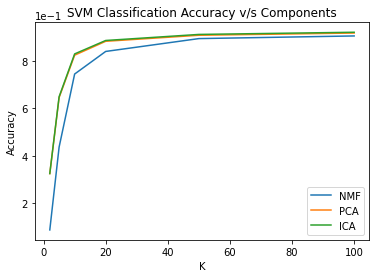

In [ ]:
# plot the different graphs for reconstruction loss

plt.plot(num_latent_space, accuracy_nmf_svm_list, label = "NMF")
plt.plot(num_latent_space, accuracy_pca_svm_list, label = "PCA")
plt.plot(num_latent_space, accuracy_ica_svm_list, label = "ICA")


path = '../results/Cross_Validation/cv_svm_accuracy'+'.png'


# naming the x axis
plt.xlabel('K')
# naming the y axis
plt.ylabel('Accuracy')

plt.title('SVM Classification Accuracy v/s Components')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.savefig(path)
plt.legend()
plt.show()


Plot Logistic Regression accuracy vs num of components

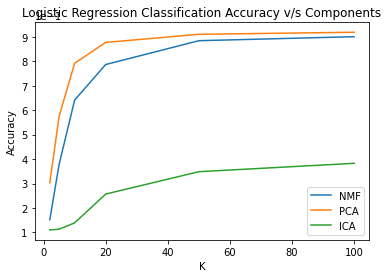

In [ ]:
# plot the different graphs for reconstruction loss

plt.plot(num_latent_space, accuracy_nmf_lr_list, label = "NMF")
plt.plot(num_latent_space, accuracy_pca_lr_list, label = "PCA")
plt.plot(num_latent_space, accuracy_ica_lr_list, label = "ICA")


path = '../results/Cross_Validation/cv_lr_accuracy'+'.png'


# naming the x axis
plt.xlabel('K')
# naming the y axis
plt.ylabel('Accuracy')

plt.title('Logistic Regression Classification Accuracy v/s Components')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.savefig(path)
plt.legend()
plt.show()
